# Convolution Network with TensorFlow


In [1]:
import pickle
import numpy as np
import tensorflow as tf

def unpickle(file):
    fo = open(file, 'rb')
    dict = pickle.load(fo, encoding='latin1')
    fo.close()
    return dict

The clean function crops and greyscales the image. The image is then normalized and the data returned. The data is normalized so that the gradient decent does not change dramatically. 

In [2]:
def clean(data):
    imgs = data.reshape(data.shape[0], 3, 32, 32)
    grayscale_imgs = imgs.mean(1)
    cropped_imgs = grayscale_imgs[:, 4:28, 4:28]
    img_data = cropped_imgs.reshape(data.shape[0], -1)
    img_size = np.shape(img_data)[1]
    means = np.mean(img_data, axis=1)
    meansT = means.reshape(len(means), 1)
    stds = np.std(img_data, axis=1)
    stdsT = stds.reshape(len(stds), 1)
    adj_stds = np.maximum(stdsT, 1.0 / np.sqrt(img_size))
    normalized = (img_data - meansT) / adj_stds
    return normalized

The read_data function sorts the images into data and labels.

In [3]:
def read_data(directory):
    names = unpickle('{}/batches.meta'.format(directory))['label_names']
    print('names', names)
    data, labels = [], []
    for i in range(1, 6):
        filename = '{}/data_batch_{}'.format(directory, i)
        batch_data = unpickle(filename)
        if len(data) > 0:
            data = np.vstack((data, batch_data['data']))
            labels = np.hstack((labels, batch_data['labels']))
        else:
            data = batch_data['data']
            labels = batch_data['labels']
    print(np.shape(data), np.shape(labels))
    data = clean(data)
    data = data.astype(np.float32)
    return names, data, labels

The dataset of images can be obtained from https://www.cs.toronto.edu/~kriz/cifar.html.

In [4]:
names, data, labels = read_data('/floyd/input/cifar_10_batches_py')

names ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
(50000, 3072) (50000,)


The show_some_examples is a to show the new images.

In [5]:
import matplotlib.pyplot as plt
import random

def show_some_examples(names, data, labels):
    plt.figure()
    rows, cols = 4, 4
    random_idxs = random.sample(range(len(data)), rows * cols)
    for i in range(rows * cols):
        plt.subplot(rows, cols, i + 1)
        j = random_idxs[i]
        plt.title(names[labels[j]])
        img = np.reshape(data[j, :], (24, 24))
        plt.imshow(img, cmap='Greys_r')
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    plt.savefig('cifar_examples.png')
show_some_examples(names, data, labels)

<Figure size 640x480 with 16 Axes>

The variable W is the set of 32 filters which are size 5 x 5. Filters help to find the significant and defining areas of a image such as edges and shapes. 

In [6]:

W = tf.Variable(tf.random_normal([5, 5, 1, 32]))

def show_weights(W, filename=None):
    plt.figure()
    rows, cols = 4, 8
    for i in range(np.shape(W)[3]):
        img = W[:, :, 0, i]
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img, cmap='Greys_r', interpolation='none')
        plt.axis('off')
    if filename:
        plt.savefig(filename)
    else:
        plt.show()

The show weights function displays the 32 filters. 

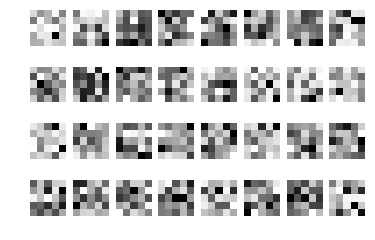

In [7]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    W_val = sess.run(W)
    show_weights(W_val, 'step0_weights.png')


In [8]:

def show_conv_results(data, filename=None):
    plt.figure()
    rows, cols = 4, 8
    for i in range(np.shape(data)[3]):
        img = data[0, :, :, i]
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img, cmap='Greys_r', interpolation='none')
        plt.axis('off')
    if filename:
        plt.savefig(filename)
    else:
        plt.show()

The images of the car shown below are the 32 convolutions of the image after applying the filters. The other set of images are the 32 convolution layers which a bias and activation function are added. These images show more defined patterns in the orginal image.

(1, 24, 24, 32)
(1, 24, 24, 32)


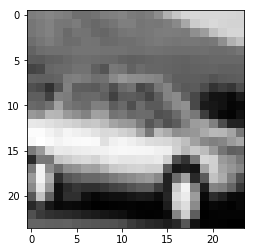

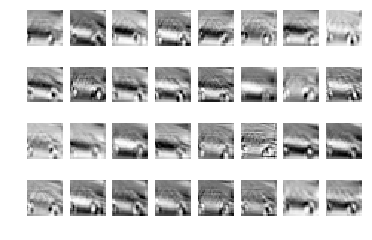

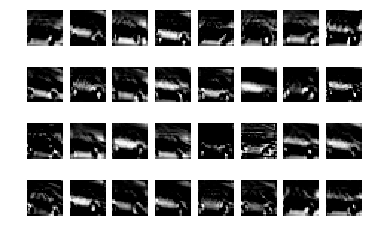

In [9]:
raw_data = data[4, :]
raw_img = np.reshape(raw_data, (24, 24))
plt.figure()
plt.imshow(raw_img, cmap='Greys_r')
plt.savefig('input_image.png')

x = tf.reshape(raw_data, shape=[-1, 24, 24, 1])

b = tf.Variable(tf.random_normal([32]))
conv = tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
conv_with_b = tf.nn.bias_add(conv, b)
conv_out = tf.nn.relu(conv_with_b)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    conv_val = sess.run(conv)
    show_conv_results(conv_val, 'step1_convs.png')
    print(np.shape(conv_val))
    conv_out_val = sess.run(conv_out)
    show_conv_results(conv_out_val, 'step2_conv_outs.png')
    print(np.shape(conv_out_val))

Defining place holders x and y. W1 and b1 are used to apply convolutions of 5x5 window size. W2 and b2 are used to apply 64 more convolutios of size 5x5. W3 and b3 are for creating a fully connected layer. W_out and b_out are variables for fully connected linear layer.

In [10]:
x = tf.placeholder(tf.float32, [None, 24 * 24])
y = tf.placeholder(tf.float32, [None, len(names)])

W1 = tf.Variable(tf.random_normal([5, 5, 1, 64]))
b1 = tf.Variable(tf.random_normal([64]))

W2 = tf.Variable(tf.random_normal([5, 5, 64, 64]))
b2 = tf.Variable(tf.random_normal([64]))

W3 = tf.Variable(tf.random_normal([6*6*64, 1024]))
b3 = tf.Variable(tf.random_normal([1024]))

W_out = tf.Variable(tf.random_normal([1024, len(names)]))
b_out = tf.Variable(tf.random_normal([len(names)]))

The conv_layer is a function to apply convolutions, add a bias and then add an activation function. 

In [11]:
def conv_layer(x, W, b):


    conv = tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
    conv_with_b = tf.nn.bias_add(conv, b)
    conv_out = tf.nn.relu(conv_with_b)
    return conv_out

Max pooling is used to reduce the dimensionality of the convolutional layer. A window is sweeped accross the image where the maximum value pixels are chosen.

In [12]:
def maxpool_layer(conv, k=2):

    return tf.nn.max_pool(conv, ksize=[1, k, k, 1], strides=[1, k, k, 1],padding='SAME')

The model constructs two convolutions layers. Max pooling is applied to both covolution layers. The model returns a fully connected layer. 

In [13]:
def model():


    x_reshaped = tf.reshape(x, shape=[-1, 24, 24, 1])

    conv_out1 = conv_layer(x_reshaped, W1, b1)
    maxpool_out1 = maxpool_layer(conv_out1)
    norm1 = tf.nn.lrn(maxpool_out1, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75)

    conv_out2 = conv_layer(norm1, W2, b2)
    norm2 = tf.nn.lrn(conv_out2, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75)
    maxpool_out2 = maxpool_layer(norm2)

    maxpool_reshaped = tf.reshape(maxpool_out2, [-1, W3.get_shape().as_list()[0]])
    local = tf.add(tf.matmul(maxpool_reshaped, W3), b3)
    local_out = tf.nn.relu(local)

    out = tf.add(tf.matmul(local_out, W_out), b_out)
    return out

The soft_max_cross_entropy_with_logits is used to minimize the cost function. This cost function is used for classification problems in which classes are mutually exclusive i.e. each image has one label only. 
The adam optimizer is used for its simplicity and speed. 
Correct prediction and accuracy are calculated to measure the preformance of the model. 

In [14]:


model_op = model()

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=model_op, labels=y))

train_op = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cost)
correct_pred = tf.equal(tf.argmax(model_op, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



The session loops through small batches of the dataset. The labels are one hot encoded for classification. The accuracy is printed every 1000 iterations to check progress.

In [16]:
with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
    sess.run(tf.global_variables_initializer())
    onehot_labels = tf.one_hot(labels, len(names), on_value=1., off_value=0.,
    axis=-1)
    onehot_vals = sess.run(onehot_labels)
    batch_size = len(data) // 200
    print('batch size', batch_size)
    for j in range(0, 150):
        print('EPOCH', j)
        for i in range(0, len(data), batch_size):
                batch_data = data[i:i+batch_size, :]
                batch_onehot_vals = onehot_vals[i:i+batch_size, :]
                _, accuracy_val = sess.run([train_op, accuracy], feed_dict={x:batch_data, y: batch_onehot_vals})
                if i % 1000 == 0:
                    print(i, accuracy_val)
        print('DONE WITH EPOCH')


batch size 250
EPOCH 0
0 0.072
1000 0.076
2000 0.096
3000 0.136
4000 0.148
5000 0.112
6000 0.192
7000 0.144
8000 0.164
9000 0.136
10000 0.152
11000 0.192
12000 0.168
13000 0.18
14000 0.184
15000 0.16
16000 0.16
17000 0.18
18000 0.184
19000 0.172
20000 0.124
21000 0.196
22000 0.2
23000 0.196
24000 0.236
25000 0.204
26000 0.2
27000 0.208
28000 0.22
29000 0.224
30000 0.204
31000 0.184
32000 0.232
33000 0.228
34000 0.216
35000 0.22
36000 0.24
37000 0.208
38000 0.2
39000 0.204
40000 0.24
41000 0.168
42000 0.244
43000 0.22
44000 0.26
45000 0.2
46000 0.236
47000 0.312
48000 0.204
49000 0.272
DONE WITH EPOCH
EPOCH 1
0 0.244
1000 0.24
2000 0.24
3000 0.236
4000 0.264
5000 0.22
6000 0.224
7000 0.272
8000 0.296
9000 0.248
10000 0.244
11000 0.268
12000 0.228
13000 0.26
14000 0.256
15000 0.28
16000 0.228
17000 0.248
18000 0.24
19000 0.232
20000 0.22
21000 0.22
22000 0.248
23000 0.256
24000 0.272
25000 0.296
26000 0.284
27000 0.268
28000 0.3
29000 0.232
30000 0.248
31000 0.268
32000 0.316
33000 0.308

## Conclusion 


The final accuracy score after 150 epochs is 0.572. The accuracy was slowly increasing and I believe it would increase further with an increase of epochs, possibly 1000 epochsin total. I was training this on a cloud service for the GPU so I wanted to limit the time spent used. But in the future I may train the model further and increase its preformance. 